# Analysis of Beer Ratings

This is an analysis of the collected Untappd data.  The goal is to generate a model for beer ratings on the Untappd website in order to predict the rating for a new beer.  

## Load data
The csv's generated in *CollectData.ipynb* are first imported. The two csv's are merged into a single data frame such that each row contains data for a single beer and details of that beer's brewery.

In [27]:
import pandas as pd
beerdf = pd.read_csv("untappd2.csv", header=None)
brewdf = pd.read_csv("breweries.csv", header=None)
beernames = ['ID', 'BeerName', 'BrewName', 'BeerType', 'BeerRate', 'ABV', 'IBU', 'NRate', 'BeerDate', 'BrewID']
brewnames = ['BrewID', 'City', 'State', 'BrewType', 'BrewRate', 'NBrew', 'NBrewRate', 'BrewDate']
beerdf.columns = beernames
brewdf.columns = brewnames
#merge the two data frames so that each row describes one beer and has data about the beer and it's brewery
full = pd.merge(beerdf, brewdf, on='BrewID', how='outer')
full.head(3)

,ID,BeerName,BrewName,BeerType,BeerRate,ABV,IBU,NRate,BeerDate,BrewID,City,State,BrewType,BrewRate,NBrew,NBrewRate,BrewDate
0,1200000,Nate's New World Kolsch,Faction Brewing,K�lsch,(3.68),4.8% ABV,37 IBU,102 Ratings,Added 08/14/15,/FactionBrewing,Alameda,CA United States,Micro Brewery,(3.79),"110,145","85,777 Ratings",Added 02/13/13
1,1200001,Dark Matter Black IPA,Bugnutty Brewing Company,IPA - Black / Cascadian Dark Ale,(3.78),6.5% ABV,67 IBU,488 Ratings,Added 07/23/16,/BugnuttyBrew,Merritt Island,FL United States,Micro Brewery,(3.68),"10,635","8,221 Ratings",Added 09/09/13
2,1200002,Pucker Punch,Golden Coast Mead,Mead - Other,(3.98),12% ABV,No IBU,84 Ratings,Added 08/14/15,/goldencoastmead,Oceanside,CA United States,Cidery / Meadery,(3.61),"9,293","7,400 Ratings",Added 01/14/12


## Clean data
Before generating our model, the specific rows and features need to be carefully filtered and cleaned.

One such filter removes all breweries/beers originating outside the USA.  Most of the data (299 out of 331 entries) is from the USA, and filtering it as such will allow a USA region feature to be added to the model.

In [28]:
print('total entries collected: ' + str(len(full)))
#We are only interested in beers from rated breweries in the us
#filter out incomplete entries
full_noNA = full.dropna()
print('total complete entries: ' + str(len(full_noNA)))
#keep only US beers
full_USA = full_noNA.loc[full_noNA.State.str.contains('United States'),:]
print('total US entries: ' + str(len(full_USA)))

total entries collected: 348
total complete entries: 331
total US entries: 299


Use regular expressions to clean the values of unwanted characters such as %, -, and redundant labels.

In [29]:
import re
#use regex to remove unwanted characters
pd.options.mode.chained_assignment = None 
#the beer type sometimes has a "-" after the type to add additional descriptors.  Keep everything before the "-".
full_USA['BeerType'] = full_USA.BeerType.str.replace(' -.*', '')
#remove the parenthesis around the rating
full_USA['BeerRate'] = full_USA.BeerRate.str.replace('(', '')
full_USA['BeerRate'] = full_USA.BeerRate.str.replace(')', '')
#extract the number for the ABV, everything before the %
full_USA['ABV'] = full_USA.ABV.str.replace('%.*', '')
full_USA['ABV'] = pd.to_numeric(full_USA['ABV'], errors='coerce')
#extract the number for IBU, everything before the %
full_USA['IBU'] = full_USA.IBU.str.replace(' IBU', '')
full_USA['IBU'] = pd.to_numeric(full_USA['IBU'], errors='coerce')
#NRate keep the number only, everything before " Ratings".
full_USA['NRate'] = full_USA.NRate.str.replace(' Ratings', '')
full_USA['NRate'] = full_USA.NRate.str.replace(',', '')
full_USA['NRate'] = pd.to_numeric(full_USA['NRate'], errors='coerce')
#Extract date
full_USA['BeerDate'] = full_USA.BeerDate.str.replace('Added ', '')
#Extract state
full_USA['State'] = full_USA.State.str.replace(' .*', '')
#Clean up brew rate
full_USA['BrewRate'] = full_USA.BrewRate.str.replace('(', '')
full_USA['BrewRate'] = full_USA.BrewRate.str.replace(')', '')
#Clean up NBrew
full_USA['NBrew'] = full_USA.NBrew.str.replace(',', '')
#Clean up NBrewRate
full_USA['NBrewRate'] = full_USA.NBrewRate.str.replace(' Ratings', '')
full_USA['NBrewRate'] = full_USA.NBrewRate.str.replace(',', '')
#Clean up date
full_USA['BrewDate'] = full_USA.BrewDate.str.replace('Added ', '')

Only certain variables from this data set are useful for machine learning, so I built a matrix of the relevant data.  The variables of interest include the type of beer, the alcohol by volume (ABV), the state of origin, the type of brewery (microbrewery, brew pub, etc.), the overall brewery rating on the website, the number of brews listed for the brewery, the total number of ratings received for beers at that brewery, and the date the brewery was added to the website.  We also keep the beer rating, which is the value we will try to predict with our model. The first five rows of data are printed below.

In [45]:
cols = ['BeerType', 'BeerRate', 'ABV', 'State', 'BrewType', 'BrewRate', 'NBrewRate', 'BrewDate']
full_USA_filter = full_USA.loc[:,cols]
full_USA_filter.head()

,BeerType,BeerRate,ABV,State,BrewType,BrewRate,NBrewRate,BrewDate
0,K�lsch,3.68,4.8,CA,Micro Brewery,3.79,85777,02/13/13
1,IPA,3.78,6.5,FL,Micro Brewery,3.68,8221,09/09/13
2,Mead,3.98,12.0,CA,Cidery / Meadery,3.61,7400,01/14/12
3,IPA,3.66,NaN,TN,Micro Brewery,3.62,72700,10/11/10
4,Witbier,3.52,4.5,OH,Micro Brewery,3.74,563853,06/29/13


Our model needs sufficient data in order to provide meaningful results.  For each variable (column), we will only keep values that are represented at least 15 times.  Values sparsly represented we recode the value as 'NA'.  Below, the beer type and brewery type are recoded in this way.  We have plenty of IPA's and Pale Ales in our data set, but other types are more sparse.

In [46]:
#View the top types of beer in our dataset
BeerTypeCounts = full_USA_filter.BeerType.value_counts()
BeerTypeCounts.head(7)

IPA                       61
Pale Ale                  23
Sour                      20
Stout                     17
Saison / Farmhouse Ale    17
Red Ale                   13
Porter                    13
Name: BeerType, dtype: int64

In [47]:
#Recode the beer types keeping only top beer types (all others at NA)
full_USA_filter.BeerType = full_USA_filter.BeerType.astype('category', categories=['IPA','Pale Ale','Sour','Saison / Farmhouse Ale', 'Stout'])
BeerTypeCounts = full_USA_filter.BeerType.value_counts()

In [48]:
#View the top brewtypes in our dataset
BrewTypeCounts = full_USA_filter.BrewType.value_counts()
BrewTypeCounts

Micro Brewery       240
Brew Pub             37
Cidery / Meadery      8
Macro Brewery         8
Nano Brewery          4
Home Brewery          2
Name: BrewType, dtype: int64

In [49]:
#Recode the brew types keeping only top brewery types
full_USA_filter.BrewType = full_USA_filter.BrewType.astype('category', categories=['Micro Brewery','Brew Pub'])

We have sparse data for each state, but should have good representation if we instead classify by region.

In [50]:
import numpy as np
#Create a Region column for US geographic areas
Midwest = ['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']
Northeast = ['CT', 'MA', 'ME', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
South = ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
West = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']

conditions = [
    (full_USA_filter.State.isin(Midwest)),
    (full_USA_filter.State.isin(Northeast)),
    (full_USA_filter.State.isin(South)),
    (full_USA_filter.State.isin(West))]

choices = ['Midwest', 'Northeast', 'South', 'West']
full_USA_filter['Region'] = np.select(conditions, choices, default = 'none')
full_USA_filter.head()

,BeerType,BeerRate,ABV,State,BrewType,BrewRate,NBrewRate,BrewDate,Region
0,NaN,3.68,4.8,CA,Micro Brewery,3.79,85777,02/13/13,West
1,IPA,3.78,6.5,FL,Micro Brewery,3.68,8221,09/09/13,South
2,NaN,3.98,12.0,CA,NaN,3.61,7400,01/14/12,West
3,IPA,3.66,NaN,TN,Micro Brewery,3.62,72700,10/11/10,South
4,NaN,3.52,4.5,OH,Micro Brewery,3.74,563853,06/29/13,Midwest


Convert all numeric values to numeric data types and the date values to datetime objects.

In [52]:
#Make sure numbers are of a numeric type, date is a date type
full_USA_filter.BeerRate = pd.to_numeric(full_USA_filter.BeerRate)
full_USA_filter.BrewRate = pd.to_numeric(full_USA_filter.BrewRate, errors='coerce')
#full_USA_filter.NBrew = pd.to_numeric(full_USA_filter.NBrew)
full_USA_filter.NBrewRate = pd.to_numeric(full_USA_filter.NBrewRate)
full_USA_filter.BrewDate = pd.to_datetime(full_USA_filter.BrewDate)
full_USA_filter.dtypes

BeerType           category
BeerRate            float64
ABV                 float64
State                object
BrewType           category
BrewRate            float64
NBrewRate             int64
BrewDate     datetime64[ns]
Region               object
dtype: object

Calculate a new variable, number of days the brewery has been listed.  Use this new variable to also calculate number of reviews per day.

In [53]:
#Create a new feature NDays, the total number of days the brewery has existed on the site.
today = pd.to_datetime('2018-06-14')
full_USA_filter['NDays'] = today - full_USA_filter.BrewDate
full_USA_filter.NDays = full_USA_filter.NDays.astype(str)
full_USA_filter['NDays'] = full_USA_filter.NDays.str.replace(' days.*', '')
full_USA_filter.NDays = pd.to_numeric(full_USA_filter.NDays)
#remove the BrewDate column, instead using the NDays calculated from the date.
full_USA_filter = full_USA_filter.drop('BrewDate', 1)
#remove the State column, instead using the Region determined from the state.
full_USA_filter = full_USA_filter.drop('State', 1)
full_USA_filter.head()

,BeerType,BeerRate,ABV,BrewType,BrewRate,NBrewRate,Region,NDays
0,NaN,3.68,4.8,Micro Brewery,3.79,85777,West,1947
1,IPA,3.78,6.5,Micro Brewery,3.68,8221,South,1739
2,NaN,3.98,12.0,NaN,3.61,7400,West,2343
3,IPA,3.66,NaN,Micro Brewery,3.62,72700,South,2803
4,NaN,3.52,4.5,Micro Brewery,3.74,563853,Midwest,1811


For the model to work, all data must be numerical.  We convert categorical data into dummy variables.  For example, the column region with values Midwest, Northeast, South, West becomes four columns (Midwest, Northeast, South, West) with values 1 or 0.

In [54]:
full_USA_filter1 = pd.get_dummies(full_USA_filter)
full_USA_filter1.head()

,BeerRate,ABV,BrewRate,NBrewRate,NDays,BeerType_IPA,BeerType_Pale Ale,BeerType_Sour,BeerType_Saison / Farmhouse Ale,BeerType_Stout,BrewType_Micro Brewery,BrewType_Brew Pub,Region_Midwest,Region_Northeast,Region_South,Region_West
0,3.68,4.8,3.79,85777,1947,0,0,0,0,0,1,0,0,0,0,1
1,3.78,6.5,3.68,8221,1739,1,0,0,0,0,1,0,0,0,1,0
2,3.98,12.0,3.61,7400,2343,0,0,0,0,0,0,0,0,0,0,1
3,3.66,NaN,3.62,72700,2803,1,0,0,0,0,1,0,0,0,1,0
4,3.52,4.5,3.74,563853,1811,0,0,0,0,0,1,0,1,0,0,0


Convert the rating y into a categorical variable.  Find the mean rating of all beers in the data set, and then make a categorical rating of 1 for above average, 0 for below average.

In [55]:
full_USA_filter1['BRCat'] = np.where(full_USA_filter1['BeerRate']>=full_USA_filter1.BeerRate.mean(), 1, 0)
full_USA_filter1 = full_USA_filter1.drop('BeerRate', 1)
full_USA_filter1.shape

(299, 16)

In [56]:
#filter out incomplete entries.  These entries do not have ABV listed
full_USA_filter1 = full_USA_filter1.dropna()
full_USA_filter1.shape

(272, 16)

## Visualization
Our matrix is getting pretty large!  Let's try some visualizations just on the continuous variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA1F4AA978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001FA1F853358>]], dtype=object)

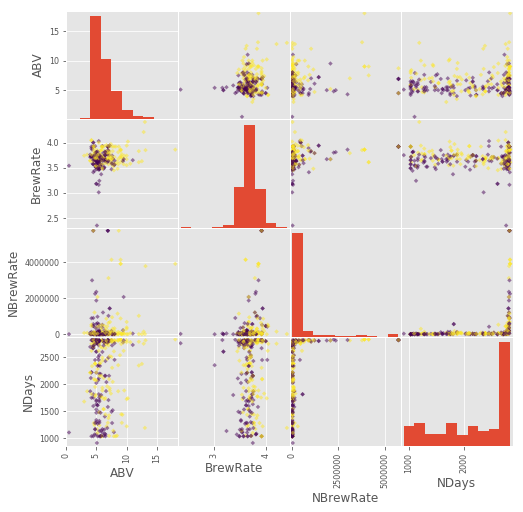

In [58]:
#Try some exploratory data analysis
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
XS = full_USA_filter1.iloc[:, :4]
pd.plotting.scatter_matrix(XS, c = full_USA_filter1['BRCat'], figsize = [8,8], s = 10, marker = 'D')

## Machine Learning Models: K-Nearest Neighbors
The visualization looks pretty messy.  Lets see what our models can do.  Break the data into train and test sets.  Use feature scaling to normalize all categories to have a range of 1.

In [59]:
#spit data into train and test
#break the feature matrix 'X' from the beer rating 'y'
y = full_USA_filter1['BRCat']
X = full_USA_filter1.drop('BRCat', 1)
#spit data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64, stratify=y)

In [60]:
#use feature scaling
from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_test_scaled = scaler.transform(X_test)

Find the optimal value for k from cross-validation.  Use this k for our model.

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
#tune hyperparameters using a cross-validation set
param_grid = {'n_neighbors': np.arange(2, 50)}
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_scaled, y_train)
print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'n_neighbors': 3}
0.636842105263


In [76]:
#set k, small k can lead to overfitting, too large k can underfit
#use optimal n_neighbors parameter from above
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print('Test set predictions:\n {}'.format(y_pred))

Test set predictions:
 [1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0
 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0
 0 0 1 0 1 1 0 1]


### K-Nearest Neighbors Performance

In [64]:
#measure accuracy for training set
knn.score(X_scaled, y_train)

0.82105263157894737

In [65]:
#measure accuracy for test set
knn.score(X_test_scaled, y_test)

0.62195121951219512

In [66]:
#generate confusion matrix
#    p0    p1
#a0  TP    FN
#a1  FP    TN
#accuracy TP + TN/(all)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[26 16]
 [15 25]]


In [67]:
from sklearn.metrics import classification_report
#precision ppv = tp/(tp+fp)
#recall = tp/(tp + fn)
#f1 score = 2*precision*recall/(precision + recall)
print(classification_report(y_test, y_pred))
#we can see that our classifier fails to correctly classify high ranking beers.

             precision    recall  f1-score   support

          0       0.63      0.62      0.63        42
          1       0.61      0.62      0.62        40

avg / total       0.62      0.62      0.62        82



## Machine Learning Model: Logistic Regression
Find the optimal regularization parameter 'C' to use with logistic regression.

In [68]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
#tune hyperparameters using a cross-validation set
from sklearn.model_selection import GridSearchCV
#param_grid = {'n_neighbors': np.arange(1, 50)}
param_grid = {'C': [0.001,0.01,0.1,1,10,100]}
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
X_s = preprocessing.scale(X)
logreg_cv.fit(X_scaled, y_train)
print(logreg_cv.best_params_)
print(logreg_cv.best_score_)

{'C': 1}
0.689473684211


In [69]:
#The regularization paramater 'C' should be adjusted to prevent over/under fitting.  Use the optimized value from above.
logreg = LogisticRegression(C = 1)
logreg.fit(X_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

### Logistic Regression Performance

In [70]:
print(confusion_matrix(y_test, y_pred))

[[30 12]
 [15 25]]


In [71]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.67      0.71      0.69        42
          1       0.68      0.62      0.65        40

avg / total       0.67      0.67      0.67        82



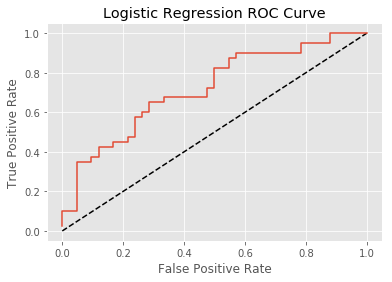

In [72]:
from sklearn.metrics import roc_curve
y_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

In [73]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_prob)

0.71845238095238095

### Logistic Regression Interpretation
If we make a table of the coefficients for logistic regression, we see that the three highest positive features (more likely to rate above average) are the alcohol by volumne (ABV), the rating of the brewery (BrewRate), and if the beer is a Stout (BeerType_Stout).  The most negative features (more likely to rate below average) are haveing a brewery in the Northeast (Region_Northeast), and having a large number of beers rated on the site (NBrewRate).

In [75]:
#Make a table of the coefficients
columns = np.array(list(X)).reshape(-1,1)
coeffs = np.reshape(logreg.coef_, (-1,1))
coeffs = np.concatenate((columns, coeffs),axis=1)
pd.DataFrame(coeffs, columns = ['Feature', 'Coeff'])

,Feature,Coeff
0,ABV,1.0033082664191102
1,BrewRate,0.8946300582234792
2,NBrewRate,-0.38127196897633125
3,NDays,0.09513122393269302
4,BeerType_IPA,0.1722110356488983
5,BeerType_Pale Ale,0.05951692530909958
6,BeerType_Sour,0.4190568353110489
7,BeerType_Saison / Farmhouse Ale,-0.011816753893708664
8,BeerType_Stout,0.516520040491474
9,BrewType_Micro Brewery,-0.12149935915081726


## Summary

The logistic regression model outperforms the k-nearest neighbors model.  The logistic regression model gives a higher f1 score. From the confusion matrix, we can see that the logistic regression model does a better job predicting which beers rate below average.

### How could this model be improved?

This sample size was very small compared to the number of beers rated on Untappd.  Would scraping more of this data help?  It depends.

Plotting the learning curve allows us to see how the performance of the model improves as additional training examples are added.  The learning curve is a plot of score (performance metric) versus m (number of samples used in training). The score of the cross validation set should increase with the number of samples, but will eventually plateau and reach a limit.  The learning curve below shows the performance of the logistic regression model.  It appears that the cross-validation set is near the performance limit even with the small sample set available. Perhaps if we gather 10X more data, we would see a 5% improvement in performance.

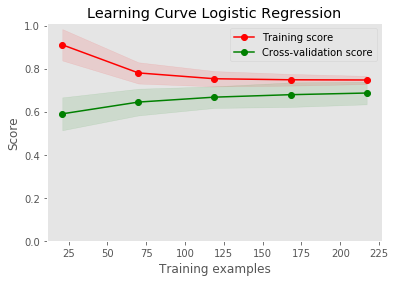

In [80]:
#plot the learning curve, would more data help?
#function from http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curve Logistic Regression"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = logreg
plot_learning_curve(estimator, title, X_s, y, ylim=(0, 1.01), cv=cv, n_jobs=4)

plt.show()

So, how could the model actually be improved?  Since the score for both the training and cross-validation sets are still a bit low, adding more features could help with this high-bias problem.  In cleaning this data, I had to remove some of the possible features, including types of beers where representation was low (lagers, hefeweizens), and I lumped states together into regions instead of keeping the state feature.  The model may or may not have benefited from adding polynomial features.  It also would have been interesting to add a population feature - what is the population of the metro-area of the brewery?

## Conclusions

Overall, I think this small project suggests that there is promise in predicting beer ratings from this accesible data.  It is important to remember that we can only attempt to predict the rating on Untappd, and this may or may not represent the opinions of beer drinkers at large.  Also, I don't have data about how these ratings correlate to actual sales - sour beers may rate well on Untappd, but how many people actually drink sour beers?  Endless possibilities!